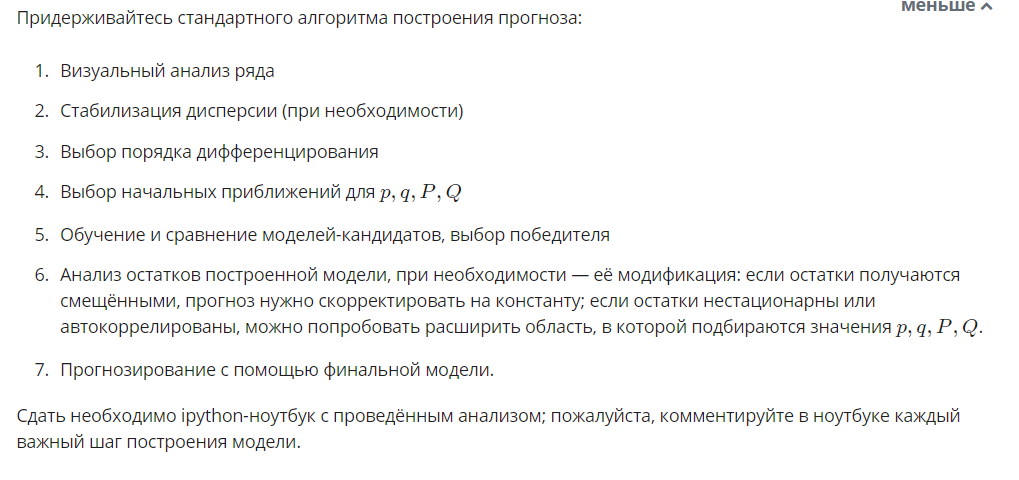

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import stats
import numpy as np

In [2]:
raw_data = pd.read_csv("WAG_C_M.csv", header=0, sep=';')

In [3]:
raw_data.head()

,month,WAG_C_M
0,01.01.1993,15.3
1,01.02.1993,19.1
2,01.03.1993,23.6
3,01.04.1993,30.6
4,01.05.1993,37.5


### Шаг 1:
Анализ графика временного ряда

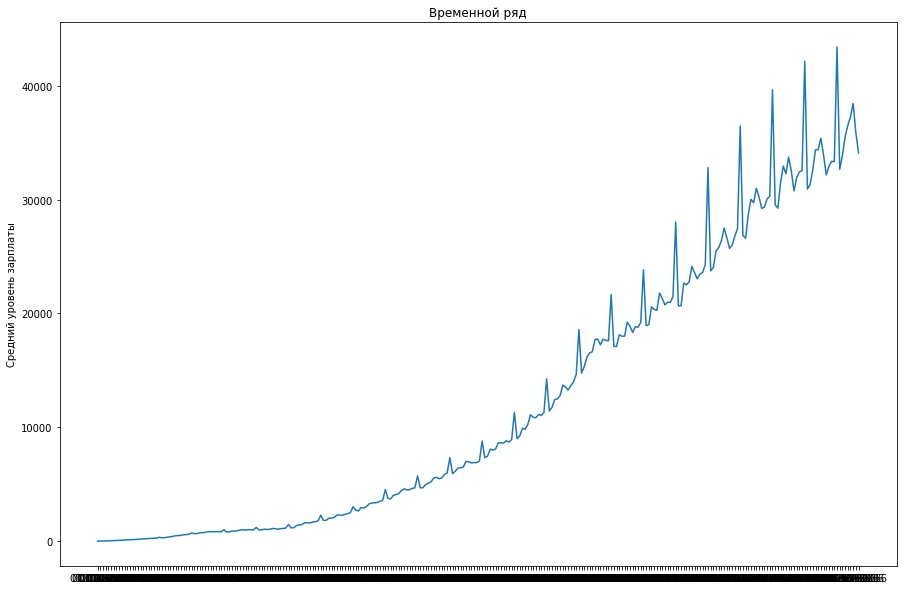

In [4]:
plt.figure(figsize=(15, 10))
plt.title("Временной ряд")
plt.ylabel("Средний уровень зарплаты")
plt.plot(raw_data.month, raw_data.WAG_C_M)

По графику видно, что дисперсия значений не равномерная значит нужно применить преобразование Бокса-Кокса

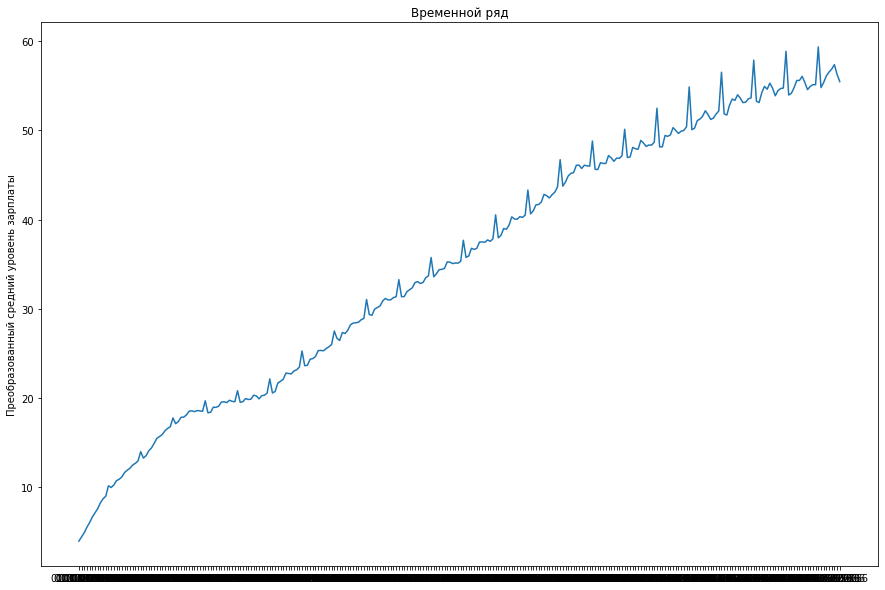

In [5]:
temp_data = raw_data.copy()

temp_data["WAG_C_M"], boc_cox_lambda = stats.boxcox(raw_data["WAG_C_M"].values)

plt.figure(figsize=(15, 10))
plt.title("Временной ряд")
plt.ylabel("Преобразованный средний уровень зарплаты")
plt.plot(temp_data.month, temp_data.WAG_C_M)

In [6]:
print("P-value критерия Дики-Фуллера: %.3f" % adfuller(temp_data.WAG_C_M)[1])

P-value критерия Дики-Фуллера: 0.697


Как и ожидалось гипотеза о нестационарности ряда не отвергается

### Шаг 2:

По ряду видно, что в нём есть тренд на рост, а также сезонность.


Сезонно продифференцируем наш ряд

In [7]:
shift_index = 0

while True:
    shift_index += 1
    shifted_data = temp_data.WAG_C_M - temp_data.WAG_C_M.shift(shift_index * 12)
    
    p_value = adfuller(shifted_data[shift_index * 12:])[1]
    if p_value < 0.05:
        print("Порядок дифференцирования %d p_value(Нестационарности) = %.3f" % (shift_index, p_value))
        temp_data["diff_data"] = shifted_data
        shift_index *= 12
        break

Порядок дифференцирования 1 p_value(Нестационарности) = 0.015


Достигаемый уровень значимости говорит нам о том, что ряд становится стационарным при порядке дифференцирования равным 1

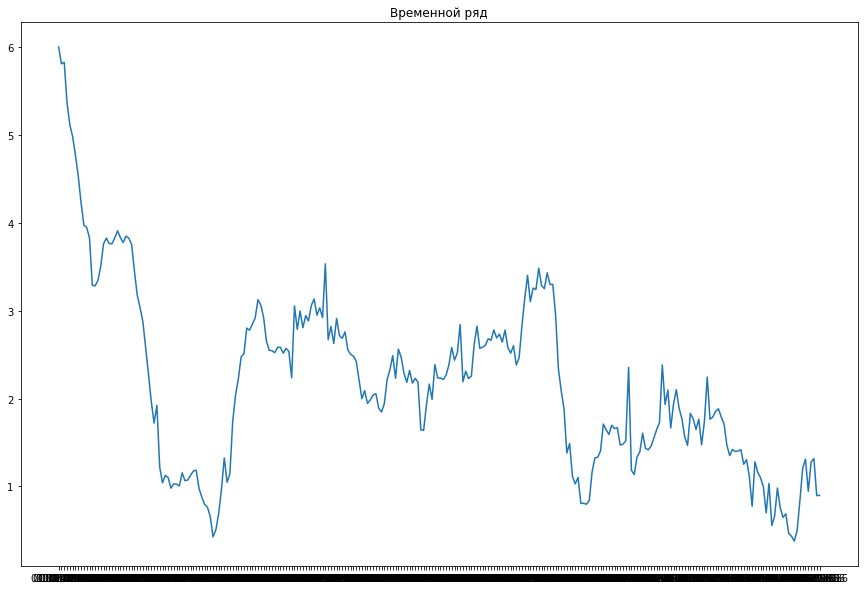

In [8]:
plt.figure(figsize=(15, 10))
plt.title("Временной ряд")
plt.plot(temp_data.month[shift_index:], temp_data.diff_data[shift_index:])

Это также видно на графике

### Шаг 3:
Построим коррелограммы, чтобы подобрать параметры Q, q, P, p

/home/as/PycharmProjects/SF/venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


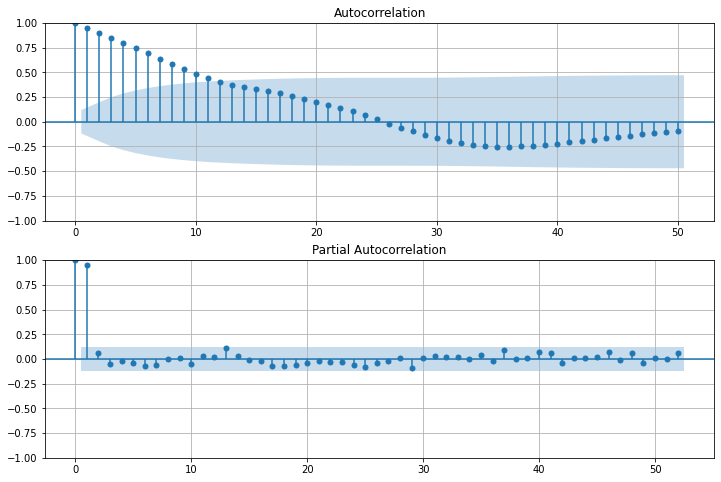

In [9]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(211)

sm.graphics.tsa.plot_acf(temp_data.diff_data[shift_index:].values.squeeze(), lags=50, ax=ax)
plt.grid()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(temp_data.diff_data[shift_index:].values.squeeze(), lags=52, ax=ax)

plt.grid()
plt.show()

* Тк мы произвели сезонное дифференцирование, то сезонности нет, поэтому Q = 0.
  Тк Q = 0, то последний значимый лаг = 11, поэтому q = 11

* По частичной коррелограмме можно сделать вывод, что все сезонные лаги незначимы, поэтому P = 0. 
  Тк P = 0, то последний значимый лаг p = 1

### Шаг 4:
Обучаем модели и выбираем лучшую

In [10]:
from itertools import product
import warnings

In [11]:
q = range(10, 13)
Q = range(2)
p = range(3)
P = range(2)
# Порядок сезонного дифференцирования
D = 1
# Порядок дифференцирования
d = 0

params = list(product(q, Q, p, P))

In [12]:
len(params)

36

In [13]:
%%time
warnings.filterwarnings('ignore')

best_model_aic = np.inf
best_model = None

for t_q, t_Q, t_p, t_P in params:
    try:
        cur_model = sm.tsa.statespace.SARIMAX(temp_data.WAG_C_M, order=(t_p, d, t_q), 
                                              seasonal_order=(t_P, D, t_Q, 12)).fit(disp=-1)
    except ValueError:
        print("Wrong params ({0}, {1}, {2}, {3})".format(t_q, t_Q, t_p, t_P))
        
    if cur_model.aic < best_model_aic:
        best_model = cur_model
        best_model_aic = cur_model.aic
        print("Best params: ", t_q, t_Q, t_p, t_P)

Best params:  10 0 0 0
Best params:  10 0 0 1
Best params:  10 0 1 0
Best params:  10 0 1 1
Best params:  10 0 2 0


KeyboardInterrupt: 

In [14]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              WAG_C_M   No. Observations:                  284
Model:             SARIMAX(2, 0, 10)x(0, 1, [], 12)   Log Likelihood                  17.262
Date:                              Tue, 26 Oct 2021   AIC                             -8.525
Time:                                      22:12:24   BIC                             38.351
Sample:                                           0   HQIC                            10.294
                                              - 284                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7533      0.203      8.633      0.000       1.355       2.151
ar.L2         -0.7546      0.201     -3.748      0.000      -1.149      -0.360
ma.L1         -0.9912      0.210     -4.723      0.000      -1.403      -0.580
ma.L2          0.2267      0.113      2.010      0.044       0.006       0.448
ma.L3          0.0537      0.097      0.552      0.581      -0.137       0.244
ma.L4          0.0546      0.100      0.544      0.587      -0.142       0.252
ma.L5          0.1203      0.121      0.997      0.319      -0.116       0.357
ma.L6         -0.0118      0.139     -0.085      0.932      -0.284       0.260
ma.L7         -0.0657      0.118     -0.555      0.579      -0.298       0.166
ma.L8          0.0188      0.119      0.159      0.874      -0.214       0.251
ma.L9          0.0615      0.121      0.507      0.612      -0.176       0.299
ma.L10        -0.1890      0.075     -2.534      0.011      -0.335      -0.043
sigma2         0.0505      0.004     14.029      0.000       0.043       0.058
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                43.01
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                             0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Шаг 5:
Посмотрим на остатки и решим, нужно ли корректировать модель

<AxesSubplot:>

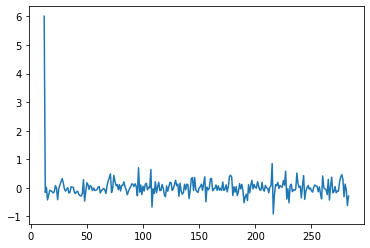

In [15]:
best_model.resid[shift_index:].plot()

На графике есть непонятный скачок в начале, но в целом данные не выглядят автокоррелированными.

Проверим несмещённость остатков с помощью критерия Стьюдента

In [16]:
stats.ttest_1samp(best_model.resid[shift_index:], 0)

Ttest_1sampResult(statistic=0.5627300840699221, pvalue=0.5740839164095093)

Тк полученный результат незначим, следовательно данные не смещены

Проверим стационарность с помощью критерия Дики-Фуллера

In [17]:
print("p-value = ", adfuller(best_model.resid[shift_index:])[1])

p-value =  0.0


Гипотеза о нестационарности уверенно отвергается, значит мы описали большую часть данных

### Шаг 6:
Спрогнозируем следующие значения

In [18]:
import datetime
from dateutil.relativedelta import relativedelta

In [19]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

In [20]:
raw_data.month.iloc[-1]

'01.08.2016'

In [21]:
prediction_df = pd.DataFrame(index=[datetime.datetime.strptime(raw_data.month.iloc[-1], "%d.%m.%Y") + relativedelta(months=i) for i in range(1, 24)], 
                             columns=["predicted_value"])

In [22]:
temp_data.shape[0]

284

In [23]:
best_model.predict(start=temp_data.shape[0], end=temp_data.shape[0] + prediction_df.shape[0]).values

array([55.92043224, 56.10889588, 56.01065001, 59.99913772, 55.16406257,
       55.62767227, 56.26395698, 56.59778595, 56.95283478, 57.52143629,
       56.47543151, 55.71019362, 56.20469362, 56.41502885, 56.33288695,
       60.33310549, 55.50644596, 55.97595871, 56.61624285, 56.95262957,
       57.30914498, 57.87838776, 56.83240066, 56.06670988])

In [24]:
prediction_df["predicted_value"] = invboxcox(
    best_model.predict(start=temp_data.shape[0], end=temp_data.shape[0] + prediction_df.shape[0] - 1).values, boc_cox_lambda
)

Построим предсказанные значения на графике:

In [25]:
x_values = np.concatenate((raw_data.month.values, [str(i.date()) for i in prediction_df.index]))
y_values = np.concatenate((raw_data.WAG_C_M.values, prediction_df.predicted_value.values))

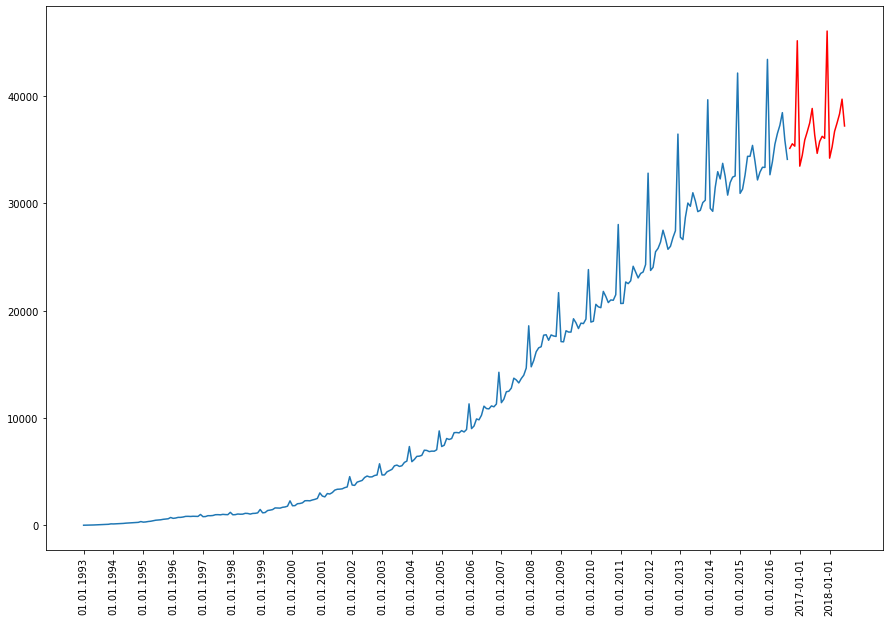

In [26]:
plt.figure(figsize=(15, 10))
plt.plot(raw_data.month.values, raw_data.WAG_C_M.values)
plt.plot([str(i.date()) for i in prediction_df.index], prediction_df.predicted_value.values, "-r")

plt.xticks(np.arange(0, raw_data.month.values.shape[0] + prediction_df.predicted_value.values.shape[0], 12), rotation=90)
plt.show()

График выглядит вполне адекватным, значит модель неплохо описала данные